In [3]:
import numpy as np
import matplotlib.pyplot as plt
from monte_carlo.hmc import *
from monte_carlo.stat_tools import binwise_chi2
from monte_carlo.markov import MetropolisUpdate

## Example of Leapforg Algorithm
Consider the simple harmonic Hamiltonian
$$
H = q^2/2 + p^2/2.
$$
The solution is harmonic oscillation in both space $q$ and momentum $p$.



In [4]:
# H = K(p) + U(q) = p^2/2 + q^2/2
# dh_dq = du_dq = q
dh_dq = lambda q: q
# dh_dp = dk_dp = p
dh_dp = lambda p: p

leapfrog = HamiltonLeapfrog(dh_dq, dh_dp, .1, 1)  # one step of size .1
def sample_motion(size, q_init, p_init, method):
    x = [(q_init, p_init)]
    for i in range(size):
        x.append(method(*x[-1]))
    return np.array(x).transpose()

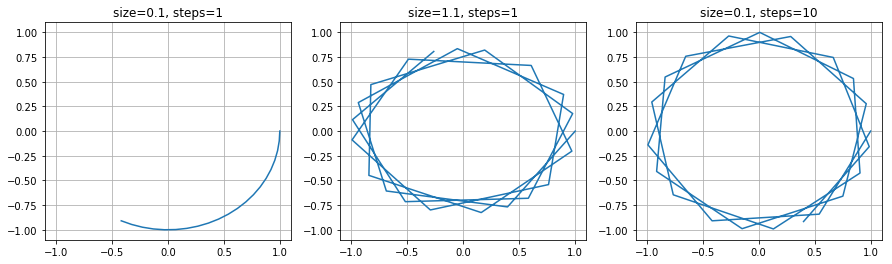

In [5]:
plt.figure(figsize=(5*3, 4))

plt.subplot(131)
leapfrog.step_size = .1
leapfrog.steps = 1
qs, ps = sample_motion(20, 1., 0., leapfrog)
plt.title("size=" + str(leapfrog.step_size) + ", steps=" + str(leapfrog.steps))
plt.plot(qs, ps)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)

plt.subplot(132)
leapfrog.step_size = 1.1
leapfrog.steps = 1
qs, ps = sample_motion(20, 1., 0., leapfrog)
plt.title("size=" + str(leapfrog.step_size) + ", steps=" + str(leapfrog.steps))
plt.plot(qs, ps)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)

plt.subplot(133)
leapfrog.step_size = .1
leapfrog.steps = 10
qs, ps = sample_motion(20, 1., 0., leapfrog)
plt.title("size=" + str(leapfrog.step_size) + ", steps=" + str(leapfrog.steps))
plt.plot(qs, ps)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.grid(True)
plt.show()

# Hamilton Monte Carlo
Have a Hamilton function with kinetic and potential terms:
$$
H(q, p) = U(q) + K(p)
$$

In analogy to canonical distribution have
$$
P(q,p) = \frac{1}{Z}\exp(-H(q,p)/T) = \frac{1}{Z} \exp(-U(q)/T) \exp(-K(p)/T) , 
$$
which means q and p are independent. The variable q is the variable of interest, where p are generally introdued to make the method work.
The above equation is used to sample q and p, such that q has the desired distribution; for T=1:
$$ U(q) = -log(P(q)) + const . $$
The distribution of p can theoretically be freely chosen. Common is a quadratic funciton in p (with $p_i$ having variance $m_i$) which leads to a multi variate Gaussian distribution.


In [11]:
# sampling a Gaussian <-> the harmonic potential

# standard metropolis algorithm with uniform proposal
s=1
pdf = lambda x: np.exp(-x**2/2/s**2) / np.sqrt(2 * np.pi * s**2)
metrop = MetropolisUpdate(1, pdf, proposal=lambda _: -4*s + 2 * 4 * s *  np.random.rand())
metrop.init_sampler(4)

# dh_dq = du_dq = q
dh_dq = lambda q: q / s**2

# hamilton monte carlo
pot = lambda q: -np.log(pdf(q)) # np.abs(q) / 2 - np.log(np.sqrt(2 * np.pi))
hmcm = HMCGaussUpdate(1, pot, dh_dq, np.ones(1), steps=10, step_size=1)
hmcm.init_sampler(0.)

Generated 5000 samples.
Generated 10000 samples.
Generated 5000 samples.
Generated 10000 samples.
Metrop acceptance rate: 0.4042, Hamilton acceptance rate: 0.9214
Metrop chi2: 4.1391, Hamiltonian chi2: 1.2940


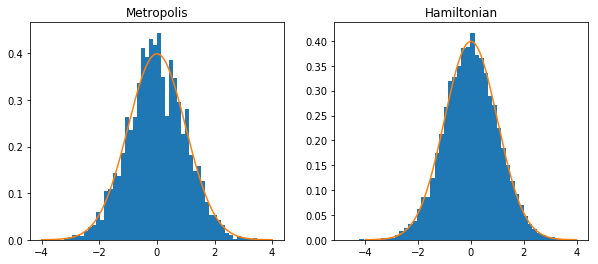

In [12]:
size = 10000
bins = 50
met_q, met_r = metrop.sample(size, True)
hmcm_q, hmcm_r = hmcm.sample(size, True)
print("Metrop acceptance rate: %.4f, Hamilton acceptance rate: %.4f" % (met_r, hmcm_r))
met_chi = binwise_chi2(pdf, met_q, bins=bins)
hmcm_chi = binwise_chi2(pdf, hmcm_q, bins=bins)
print("Metrop chi2: %.4f, Hamiltonian chi2: %.4f" % (met_chi, hmcm_chi))

x = np.linspace(-4*s, 4*s, 1000)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Metropolis")
plt.hist(met_q, bins=bins, normed=True)
plt.plot(x, pdf(x))


plt.subplot(122)
plt.title("Hamiltonian")
plt.hist(hmcm_q, bins=bins, normed=True)
plt.plot(x, pdf(x))
plt.show()

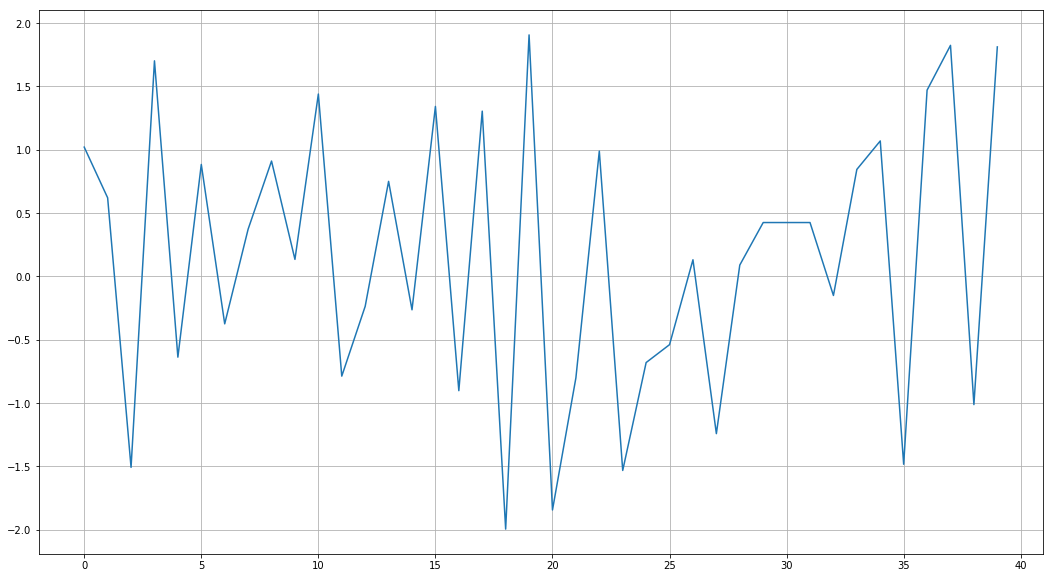

In [16]:
plt.figure(figsize=(18, 10))
plt.plot(hmcm_q[:40])
plt.grid()
plt.show()